In [1]:
# The following code will only execute
# successfully when compression is complete

# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "./dataset/labels.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "alifwr/3d-car-model",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipykernel_35/2853642044.py:13: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:              file_name                                            caption
0  00110/frame_226.jpg  The car's front doors are both closed, while t...
1   10100/frame_54.jpg  The car's front left door is open while the fr...
2   11000/frame_43.jpg  The car's front doors are both open, with the ...
3   00011/frame_42.jpg  The car's front doors are both closed, while t...
4  11111/frame_234.jpg  The car's front doors are both open, with the ...


In [2]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Optimizer, lr_scheduler
from torch.nn import Module
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import gc

2025-06-03 07:53:00.072812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748937180.266211      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748937180.322525      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class VisualCaptioningDataset(Dataset):
    def __init__(
        self, csv_file: str, dataset_dir: str, processor, max_length: int = 128
    ):
        self.processor = processor
        self.max_length = max_length
        self.dataset_dir = dataset_dir
        df = pd.read_csv(csv_file)
        self.image_paths = df["file_name"]
        self.captions = df["caption"]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image_path = self.image_paths.iloc[idx]
        image = Image.open(f"{self.dataset_dir}/{image_path}").convert("RGB")

        caption = str(self.captions.iloc[idx])

        encoding = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        encoding = {k: v.squeeze() for k, v in encoding.items()}

        return encoding

In [4]:
def train_val_model(
    model: Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: Optimizer,
    scheduler: lr_scheduler = None,
    num_epochs: int = 20,
    device: torch.device = "cuda",
    save_path: str = "best_model.pth",
):
    model = model.to(device)
    train_losses = []
    val_losses = []

    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False
        )
        for batch in train_pbar:
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids,
            )

            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

            del input_ids, pixel_values, attention_mask, outputs, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(
            val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False
        )
        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch["input_ids"].to(device)
                pixel_values = batch["pixel_values"].to(device)
                attention_mask = batch["attention_mask"].to(device)

                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids,
                )

                val_loss += outputs.loss.item()

                val_pbar.set_postfix({"loss": f"{outputs.loss.item():.4f}"})

                del input_ids, pixel_values, attention_mask, outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()

        current_val_loss = val_loss / len(val_loader)
        val_losses.append(current_val_loss)

        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            model.save_pretrained("finetuned_blip_best")
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": best_val_loss,
                },
                save_path,
            )
            print(f"✓ New best model saved! Val Loss: {best_val_loss:.4f}")

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}")
        print(f"Val Loss: {current_val_loss:.4f} (Best: {best_val_loss:.4f})")

        if scheduler is not None:
            scheduler.step()

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_val_loss": best_val_loss,
    }

In [5]:
processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base", use_fast=True
)
model = AutoModelForImageTextToText.from_pretrained(
    "Salesforce/blip-image-captioning-base"
)

dataset = VisualCaptioningDataset(
    csv_file="/kaggle/input/3d-car-model/dataset/labels.csv", 
    dataset_dir="/kaggle/input/3d-car-model/dataset", 
    processor=processor
)

train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
best_val_loss = float("inf")

model, metrics = train_val_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    device=device
)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Epoch 1/10 [Train]:   0%|          | 0/640 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✓ New best model saved! Val Loss: 0.1282

Epoch 1/10
Train Loss: 0.5774
Val Loss: 0.1282 (Best: 0.1282)


✓ New best model saved! Val Loss: 0.1100

Epoch 2/10
Train Loss: 0.1150
Val Loss: 0.1100 (Best: 0.1100)


✓ New best model saved! Val Loss: 0.0971

Epoch 3/10
Train Loss: 0.0994
Val Loss: 0.0971 (Best: 0.0971)


✓ New best model saved! Val Loss: 0.0934

Epoch 4/10
Train Loss: 0.0896
Val Loss: 0.0934 (Best: 0.0934)


✓ New best model saved! Val Loss: 0.0872

Epoch 5/10
Train Loss: 0.0824
Val Loss: 0.0872 (Best: 0.0872)



Epoch 6/10
Train Loss: 0.0778
Val Loss: 0.0912 (Best: 0.0872)



Epoch 7/10
Train Loss: 0.0780
Val Loss: 0.0874 (Best: 0.0872)


✓ New best model saved! Val Loss: 0.0869

Epoch 8/10
Train Loss: 0.0711
Val Loss: 0.0869 (Best: 0.0869)



Epoch 9/10
Train Loss: 0.0687
Val Loss: 0.0879 (Best: 0.0869)



Epoch 10/10
Train Loss: 0.0669
Val Loss: 0.0928 (Best: 0.0869)


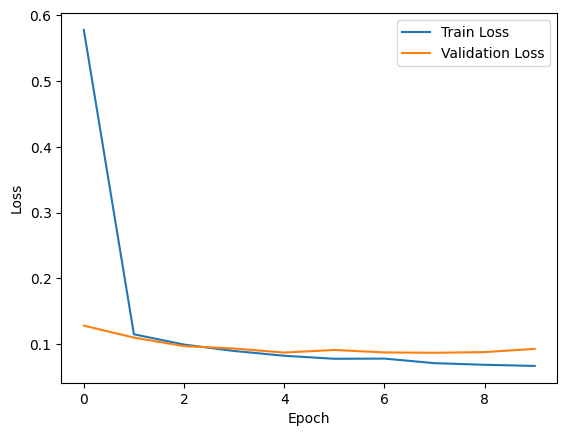

In [6]:
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]

np.save("train_losses.npy", train_losses)
np.save("val_losses.npy", val_losses)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
# del input_ids, pixel_values, attention_mask, outputs
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
# gc.collect()

In [8]:
# # Training loop with tqdm and memory management
# num_epochs = 5
# best_val_loss = float("inf")

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     train_loss = 0
#     train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
#     for i, batch in enumerate(train_loop):
#         input_ids = batch["input_ids"].to(device)
#         pixel_values = batch["pixel_values"].to(device)
#         attention_mask = batch["attention_mask"].to(device)

#         outputs = model(
#             pixel_values=pixel_values,
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             labels=input_ids
#         )

#         loss = outputs.loss
#         train_loss += loss.item()

#         loss.backward()

#         optimizer.step()
#         optimizer.zero_grad()

#         # Clear batch data
#         del input_ids, pixel_values, attention_mask, outputs, loss
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()
#         gc.collect()

#         # Update tqdm progress bar with current loss
#         train_loop.set_postfix({"Batch Loss": train_loss / (i + 1)})

#     avg_train_loss = train_loss / len(train_loader)

#     # Validation
#     model.eval()
#     val_loss = 0
#     val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
#     with torch.no_grad():
#         for batch in val_loop:
#             input_ids = batch["input_ids"].to(device)
#             pixel_values = batch["pixel_values"].to(device)
#             attention_mask = batch["attention_mask"].to(device)

#             outputs = model(
#                 pixel_values=pixel_values,
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 labels=input_ids
#             )

#             val_loss += outputs.loss.item()

#             # Clear batch data
#             del input_ids, pixel_values, attention_mask, outputs
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()
#             gc.collect()

#             # Update tqdm progress bar
#             val_loop.set_postfix({"Batch Val Loss": val_loss / (len(val_loop) + 1)})

#     avg_val_loss = val_loss / len(val_loader)

#     # Save best model
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         model.save_pretrained("finetuned_blip_best")
#         processor.save_pretrained("finetuned_blip_best")

#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

In [9]:
# from PIL import Image

# model.eval()
# image = Image.open("/kaggle/input/3d-car-model/dataset/00001/frame_100.jpg").convert("RGB")
# inputs = processor(images=image, return_tensors="pt").to(device)
# outputs = model.generate(**inputs, max_length=50)
# caption = processor.decode(outputs[0], skip_special_tokens=True)
# print(f"Generated Caption: {caption}")

In [10]:
# from PIL import Image

# model.eval()
# image = Image.open("/kaggle/input/3d-car-model/dataset/11111/frame_100.jpg").convert("RGB")
# inputs = processor(images=image, return_tensors="pt").to(device)
# outputs = model.generate(**inputs, max_length=50)
# caption = processor.decode(outputs[0], skip_special_tokens=True)
# print(f"Generated Caption: {caption}")